# 02 - Segmentation Validation

## Imports

In [1]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import avn.dataloading as dataloading
import avn.segmentation as segmentation
import avn.plotting
import math
import sklearn
import seaborn as sns

c:\Users\tkoch\anaconda3\envs\fresh_avn_dev\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_file']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

## Get List of Birds

In [3]:
All_Birds = ["B145", "B236", "B258", "B385", "B402", "B447", 
             "B507", "G255", "G397", "G402", "G413", "G437", 
             "G439", "G524", "G528", "O144", "O254", "O421", 
             "O440", "O512", "R402", "R425", "R469", "S132", 
             "S421", "S525", "S528", "Y389", "Y397", "Y425", 
             "Y440", "B524", "O434", "Y433", "Y453"] 

#All_Birds should contain 35 bird IDs. Check: 
len(All_Birds)

35

## Dataset Information

In [4]:
n_files = []

for Bird_ID in All_Birds:
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'
    seg_data = pd.read_csv(ground_truth_path)
    n_files.append((len(seg_data.files.unique())))
    

In [5]:
print(min(n_files))
print(max(n_files))
print(np.median(n_files))

17
65
48.0


# Onsets

## Calc F1 Scores

In [7]:
all_seg_metrics = pd.DataFrame()
for Bird_ID in All_Birds[:]:

    #load whisperseg segmentation and reformat so it's consistent with avn
    wseg_segmentations = pd.read_csv('D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv")
    wseg_segmentations = wseg_segmentations.drop(columns = ['Unnamed: 0', 'cluster'])
    wseg_segmentations = wseg_segmentations.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})
    
    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, wseg_segmentations)
    #load ground truth segmentation and add to seg_data object
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    #seg_data = add_ev_song_truth_table(seg_data, ground_truth_path)

    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.01
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #load tweetynet segmentations
    tweety_segs = pd.read_csv('D:\\Final_Bird_Dataset\\Old_Tweety_Segmentation\\' + Bird_ID + '.annot.csv')
    tweety_segs = vak_to_syll_table(tweety_segs)

    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, tweety_segs)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    #seg_data = add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate F1 score for Tweetynet
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.01
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])



In [8]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.918782,1.000000,0.849765,B145,0.05,whisper_seg
0,0.860104,0.954023,0.783019,B145,0.01,whisper_seg
0,0.838174,0.831276,0.845188,B145,0.05,Tweety_net
0,0.699739,0.761364,0.647343,B145,0.01,Tweety_net
0,0.937974,0.988711,0.892190,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.984900,0.985811,0.983990,Y433,0.01,Tweety_net
0,0.973851,0.998958,0.949975,Y453,0.05,whisper_seg
0,0.941086,0.970542,0.913366,Y453,0.01,whisper_seg
0,0.974070,0.970746,0.977418,Y453,0.05,Tweety_net


## Get RMSE segmentation metrics

In [9]:
all_F1s = pd.DataFrame()

for i, Bird_ID in enumerate(All_Birds):
    print("Bird: " + str(i) + "/" + str(len(All_Birds)))
    
    song_folder = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/"+ Bird_ID + "/"
    ground_truth_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/" + Bird_ID + "/" + Bird_ID + "_syll_table.csv"
    
    #do RMSE Derivative Segmentation
    segmenter = segmentation.RMSEDerivative()
    seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                 upper_threshold = 0.006, 
                                                 lower_threshold = -0.1)
    
    #Add ground truth data
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate f1 score
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    #add f1 score to dataframe
    seg_metrics = seg_data.seg_metrics
    seg_metrics["Bird_ID"] = [Bird_ID]
    all_F1s = all_F1s.append(seg_metrics)


Bird: 0/35
Bird: 1/35
Bird: 2/35
Bird: 3/35
Bird: 4/35
Bird: 5/35
Bird: 6/35
Bird: 7/35
Bird: 8/35
Bird: 9/35
Bird: 10/35
Bird: 11/35
Bird: 12/35
Bird: 13/35
Bird: 14/35
Bird: 15/35
Bird: 16/35
Bird: 17/35
Bird: 18/35
Bird: 19/35
Bird: 20/35
Bird: 21/35
Bird: 22/35
Bird: 23/35
Bird: 24/35
Bird: 25/35
Bird: 26/35
Bird: 27/35
Bird: 28/35
Bird: 29/35
Bird: 30/35
Bird: 31/35
Bird: 32/35
Bird: 33/35
Bird: 34/35


In [10]:
all_F1s['method'] = 'RMSE'
all_F1s['max_gap'] = 0.01

In [11]:
all_seg_metrics = pd.concat([all_seg_metrics, all_F1s])

In [12]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.918782,1.000000,0.849765,B145,0.05,whisper_seg
0,0.860104,0.954023,0.783019,B145,0.01,whisper_seg
0,0.838174,0.831276,0.845188,B145,0.05,Tweety_net
0,0.699739,0.761364,0.647343,B145,0.01,Tweety_net
0,0.937974,0.988711,0.892190,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.674850,0.612571,0.751226,Y440,0.01,RMSE
0,0.710714,0.700704,0.721014,B524,0.01,RMSE
0,0.573384,0.527190,0.628451,O434,0.01,RMSE
0,0.698911,0.596628,0.843521,Y433,0.01,RMSE


In [13]:
all_seg_metrics.to_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s.csv')

## Plot F1 Scores

In [3]:
all_seg_metrics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s.csv')

In [13]:
#this bird seems to have had poor viral expression for FP1KD so we're leaving it out. 
all_seg_metrics = all_seg_metrics[all_seg_metrics.Bird_ID != 'S389']

In [14]:
#load bird conditions
all_birds = pd.read_csv("D:\\Final_Bird_Dataset\\old_Bird_list.csv")
all_seg_metrics = pd.merge(all_seg_metrics, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

In [15]:
#set higher level groups from conditions
group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
all_seg_metrics['Group'] = [group_dict[x] for x in all_seg_metrics.Condition]

In [16]:
import seaborn as sns

In [17]:
#plot only scores with allowance of 10ms
all_seg_metrics = all_seg_metrics[all_seg_metrics.max_gap == 0.01]

In [18]:
#reorder categories for plotting
all_seg_metrics.method = pd.Categorical(all_seg_metrics.method).reorder_categories(['RMSE', 'Tweety_net', 'whisper_seg'])
all_seg_metrics.method = all_seg_metrics.method.cat.rename_categories({'Tweety_net' : "TweetyNet", 
                                                                       'whisper_seg' : "WhisperSeg"})

In [19]:
plt.rcParams.update({'font.size': 10})

In [20]:
all_seg_metrics.groupby('method').mean(numeric_only=True)

,F1,precision,recall,max_gap
method,,,,
RMSE,0.591932,0.552230,0.643340,0.01
TweetyNet,0.823950,0.879340,0.789961,0.01
WhisperSeg,0.881746,0.972087,0.816057,0.01


In [21]:
from scipy.stats import sem
print(sem(all_seg_metrics[all_seg_metrics.method == 'WhisperSeg'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'TweetyNet'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'RMSE'].F1))

0.01537009149584627
0.025762225287049374
0.022298506516134492


In [22]:
all_seg_metrics.groupby(['method', 'Group']).mean(numeric_only=True)

F1  precision    recall  max_gap
method     Group                                          
RMSE       FP1 KD   0.587609   0.554776  0.630351     0.01
           Isolate  0.583149   0.528371  0.655947     0.01
           Normal   0.596959   0.560883  0.642844     0.01
TweetyNet  FP1 KD   0.787970   0.924633  0.715029     0.01
           Isolate  0.813244   0.828697  0.803781     0.01
           Normal   0.840826   0.883744  0.810660     0.01
WhisperSeg FP1 KD   0.849318   0.978986  0.760159     0.01
           Isolate  0.934973   0.970569  0.903424     0.01
           Normal   0.871805   0.970279  0.800674     0.01

Text(0.5, 0, 'Method')

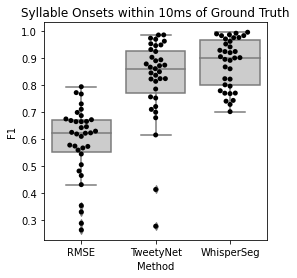

In [23]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


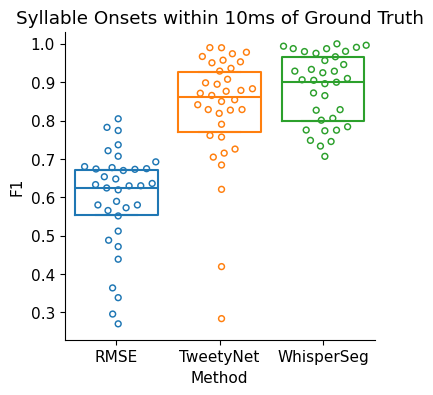

In [34]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'method', s = 8, marker = "$\circ$")
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', fill = False, hue = 'method', fliersize=0, whis = 0)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
sns.despine()

C:\Users\tkoch\AppData\Local\Temp\ipykernel_27964\3566996041.py:4: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0,


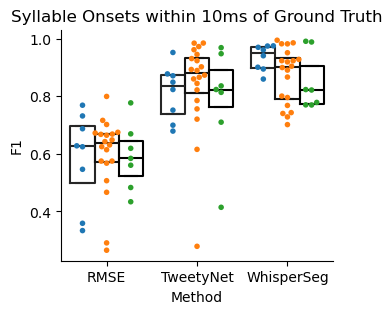

In [34]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'Group', s = 4, 
              dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
sns.despine()
plt.savefig('utsw_onsets_f1.svg', transparent = True)

Text(0, 0.5, 'Precision')

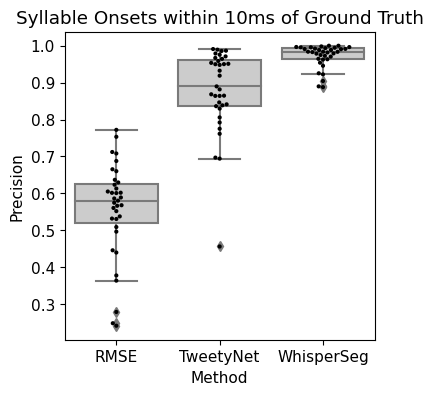

In [39]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'black', s = 3)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

Text(10.347222222222223, 0.5, 'Precision')

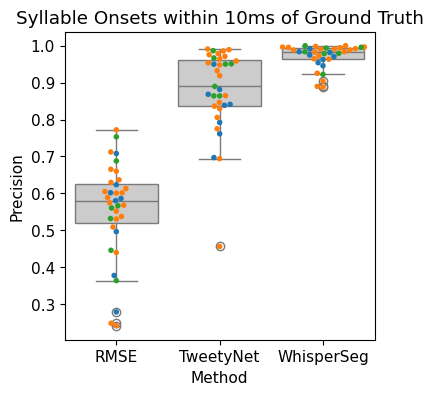

In [76]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 4,)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_27964\153721378.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0,


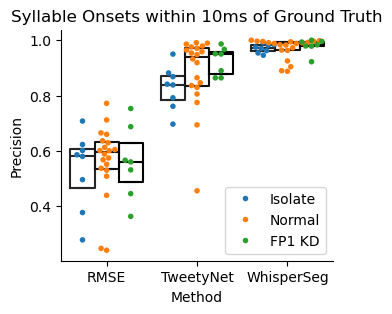

In [33]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 4, dodge = True,)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')
plt.legend(loc = 'lower right')
sns.despine()

plt.savefig('utsw_onsets_precision.svg', transparent = True)

Text(0, 0.5, 'Recall')

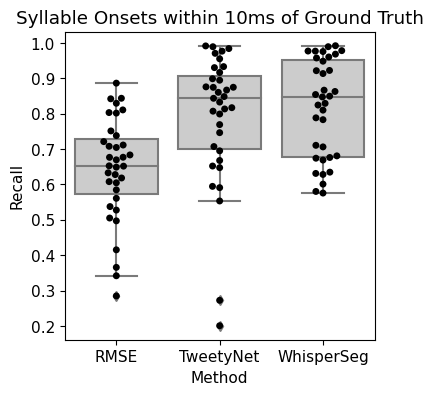

In [41]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

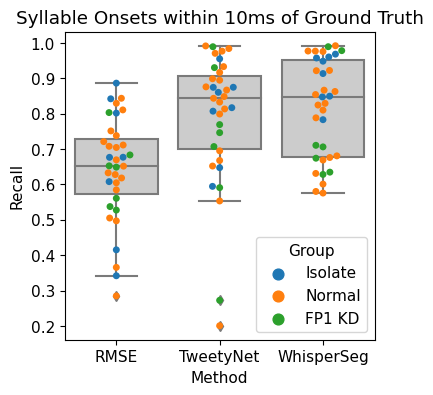

In [42]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_27964\2644323371.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0,


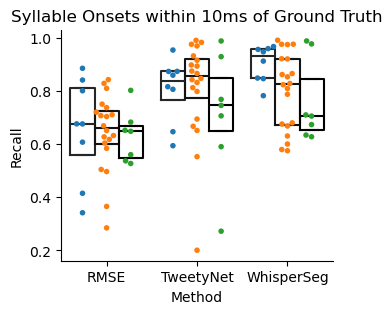

In [32]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 4, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')
sns.despine()

plt.savefig('utsw_onsets_recall.svg', transparent = True)

# Offsets

## Calc F1 Scores

In [24]:
all_seg_metrics = pd.DataFrame()
for Bird_ID in All_Birds[:]:

    #load whisperseg segmentation and reformat so it's consistent with avn
    wseg_segmentations = pd.read_csv('D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv")
    wseg_segmentations = wseg_segmentations.drop(columns = ['Unnamed: 0', 'cluster'])
    wseg_segmentations = wseg_segmentations.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})
    
    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, wseg_segmentations)
    #load ground truth segmentation and add to seg_data object
    ground_truth_path = 'C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/' + Bird_ID + '/' + Bird_ID + '_syll_table.csv'
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.02
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #load tweetynet segmentations
    tweety_segs = pd.read_csv('D:\\Final_Bird_Dataset\\Old_Tweety_Segmentation\\' + Bird_ID + '.annot.csv')
    tweety_segs = vak_to_syll_table(tweety_segs)

    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, tweety_segs)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate F1 score for Tweetynet
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature= 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.02
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])



In [25]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.920716,0.994475,0.857143,B145,0.05,whisper_seg
0,0.707379,0.780899,0.646512,B145,0.02,whisper_seg
0,0.739130,0.699588,0.783410,B145,0.05,Tweety_net
0,0.660194,0.680000,0.641509,B145,0.02,Tweety_net
0,0.942178,0.988711,0.899829,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.987989,0.987685,0.988293,Y433,0.02,Tweety_net
0,0.972124,0.998958,0.946693,Y453,0.05,whisper_seg
0,0.842611,0.867639,0.818987,Y453,0.02,whisper_seg
0,0.969756,0.969283,0.970229,Y453,0.05,Tweety_net


## Get RMSE segmentation metrics

In [26]:
all_F1s = pd.DataFrame()

for i, Bird_ID in enumerate(All_Birds):
    print("Bird: " + str(i) + "/" + str(len(All_Birds)))
    
    song_folder = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/"+ Bird_ID + "/"
    ground_truth_path = "C:/Grad_School/Code_and_software/Py_code/March_2021_redo/redo_data/segmented_songs/" + Bird_ID + "/" + Bird_ID + "_syll_table.csv"
    
    #do MFCC Segmentation
    segmenter = segmentation.RMSEDerivative()
    seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                 upper_threshold = 0.006, 
                                                 lower_threshold = -0.1)
    
    #Add ground truth data
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature= 'offsets')
    
    seg_metrics = seg_data.seg_metrics
    seg_metrics["Bird_ID"] = [Bird_ID]
    all_F1s = all_F1s.append(seg_metrics)


Bird: 0/35
Bird: 1/35
Bird: 2/35
Bird: 3/35
Bird: 4/35
Bird: 5/35
Bird: 6/35
Bird: 7/35
Bird: 8/35
Bird: 9/35
Bird: 10/35
Bird: 11/35
Bird: 12/35
Bird: 13/35
Bird: 14/35
Bird: 15/35
Bird: 16/35
Bird: 17/35
Bird: 18/35
Bird: 19/35
Bird: 20/35
Bird: 21/35
Bird: 22/35
Bird: 23/35
Bird: 24/35
Bird: 25/35
Bird: 26/35
Bird: 27/35
Bird: 28/35
Bird: 29/35
Bird: 30/35
Bird: 31/35
Bird: 32/35
Bird: 33/35
Bird: 34/35


In [27]:
all_F1s['method'] = 'RMSE'
all_F1s['max_gap'] = 0.02

In [28]:
all_seg_metrics = pd.concat([all_seg_metrics, all_F1s])

In [29]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.920716,0.994475,0.857143,B145,0.05,whisper_seg
0,0.707379,0.780899,0.646512,B145,0.02,whisper_seg
0,0.739130,0.699588,0.783410,B145,0.05,Tweety_net
0,0.660194,0.680000,0.641509,B145,0.02,Tweety_net
0,0.942178,0.988711,0.899829,B236,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.024459,0.022273,0.027121,Y440,0.02,RMSE
0,0.046058,0.045455,0.046679,B524,0.02,RMSE
0,0.048767,0.044769,0.053550,O434,0.02,RMSE
0,0.035398,0.030225,0.042709,Y433,0.02,RMSE


In [83]:
all_seg_metrics.to_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_offsets.csv')

## Plot F1 Scores

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt

In [36]:
all_seg_metrics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_offsets.csv')

In [37]:
#this bird seems to have had poor viral expression for FP1KD so we're leaving it out. 
all_seg_metrics = all_seg_metrics[all_seg_metrics.Bird_ID != 'S389']

In [38]:
#load conditions of birds from file
all_birds = pd.read_csv("D:\\Final_Bird_Dataset\\old_Bird_list.csv")
all_seg_metrics = pd.merge(all_seg_metrics, all_birds[['Bird_ID', 'Condition']], on = 'Bird_ID')

In [39]:
#create higher-level groups from conditions
group_dict = {'Isolate' : 'Isolate', 
              'GFP' : 'Normal', 
              'FP1_KD_pre_tut' : 'FP1 KD', 
              'FP1_KD_post_tut' : 'Normal'}
all_seg_metrics['Group'] = [group_dict[x] for x in all_seg_metrics.Condition]

In [40]:
import seaborn as sns

In [41]:
all_seg_metrics = all_seg_metrics[all_seg_metrics.max_gap == 0.02]

In [42]:
all_seg_metrics.method = pd.Categorical(all_seg_metrics.method).reorder_categories(['RMSE', 'Tweety_net', 'whisper_seg'])
all_seg_metrics.method = all_seg_metrics.method.cat.rename_categories({'Tweety_net' : "TweetyNet", 
                                                                       'whisper_seg' : "WhisperSeg"})

In [44]:
plt.rcParams.update({'font.size': 10})

In [45]:
all_seg_metrics.groupby('method').mean(numeric_only  = True)

,Unnamed: 0,F1,precision,recall,max_gap
method,,,,,
RMSE,0.0,0.076765,0.073769,0.080818,0.02
TweetyNet,0.0,0.837624,0.883561,0.808205,0.02
WhisperSeg,0.0,0.781196,0.855747,0.726302,0.02


In [46]:
from scipy.stats import sem
print(sem(all_seg_metrics[all_seg_metrics.method == 'WhisperSeg'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'TweetyNet'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'RMSE'].F1))

0.03319168504485945
0.029045549321172898
0.010012048017091874


In [47]:
all_seg_metrics.groupby(['method', 'Group']).mean(numeric_only = True)

Unnamed: 0        F1  precision    recall  max_gap
method     Group                                                      
RMSE       FP1 KD          0.0  0.107833   0.104428  0.112407     0.02
           Isolate         0.0  0.085638   0.080201  0.092885     0.02
           Normal          0.0  0.062342   0.060465  0.064936     0.02
TweetyNet  FP1 KD          0.0  0.749308   0.844480  0.691431     0.02
           Isolate         0.0  0.846604   0.853147  0.845113     0.02
           Normal          0.0  0.864941   0.909405  0.834313     0.02
WhisperSeg FP1 KD          0.0  0.700561   0.805352  0.628992     0.02
           Isolate         0.0  0.874748   0.905237  0.847545     0.02
           Normal          0.0  0.771997   0.853589  0.711863     0.02

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Method')

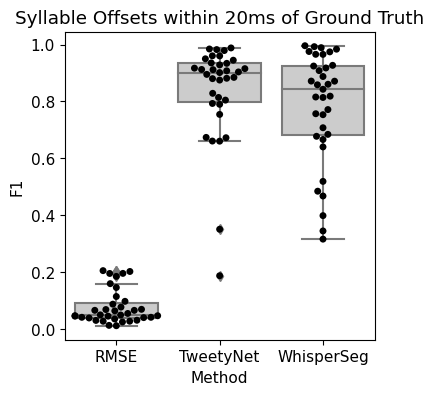

In [56]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')

c:\Users\tkoch\anaconda3\envs\avn_install_test\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 8.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Method')

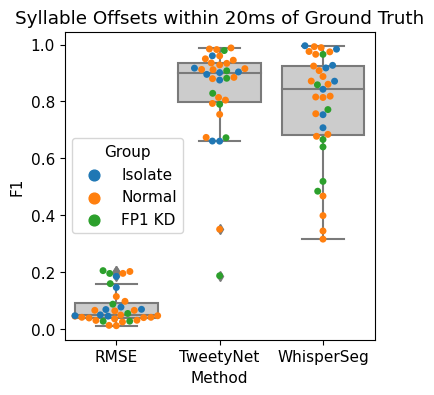

In [57]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'Group', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_27964\1732434419.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0,


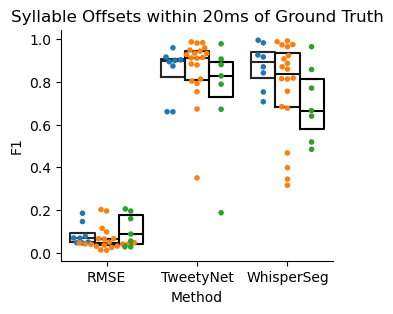

In [49]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', hue = 'Group', s = 4, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'F1', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
sns.despine()
plt.savefig('utsw_offsets_F1.svg', transparent = True)

Text(0, 0.5, 'Precision')

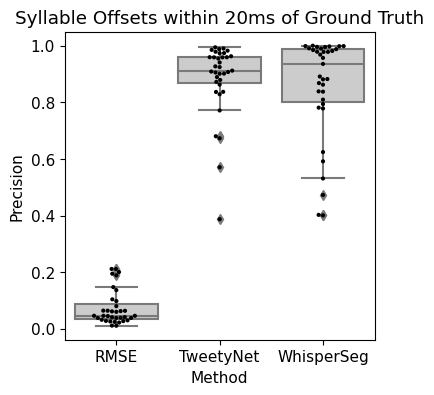

In [58]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'black', s = 3)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

Text(0, 0.5, 'Precision')

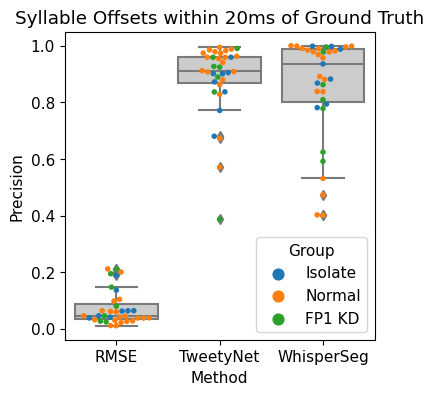

In [62]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 4)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_27964\2009677940.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0,


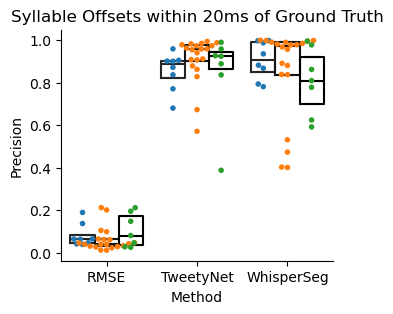

In [51]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', hue = 'Group', s = 4, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'precision', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')
sns.despine()
plt.savefig('utsw_offsets_precision.svg', transparent = True)

Text(0, 0.5, 'Recall')

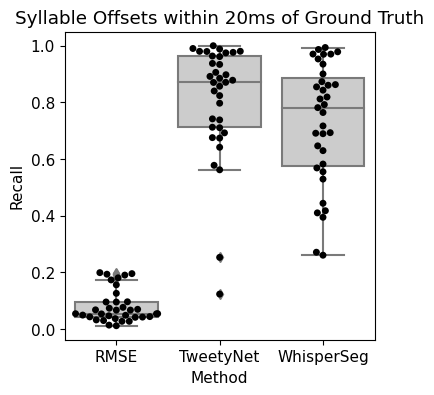

In [60]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

Text(0, 0.5, 'Recall')

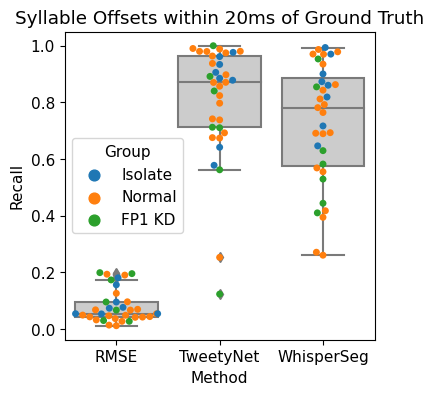

In [61]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')

C:\Users\tkoch\AppData\Local\Temp\ipykernel_27964\3504440640.py:3: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0,


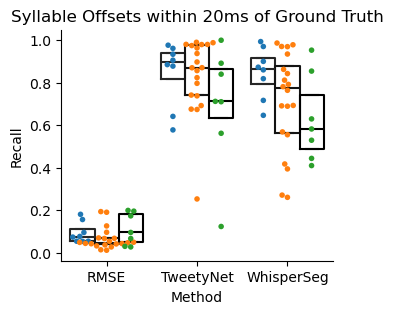

In [52]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', hue = 'Group', s = 4, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', hue = 'Group', y = 'recall', fill = False, color = 'black', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')
sns.despine()
plt.savefig('utsw_offsets_recall.svg', transparent = True)